# Exercise 9.2: The Quantum Mechanical Finite Square Well

The goal of this problem is to calculate the eigenvalues of the quantum-mechanical finite square well, first examined in Exercise 1.2. This time we will use the "shooting method". 

The potential is given by: 

$$
V(x)=
\begin{cases}
-V_0& \quad \text{if $-a \leq x \leq a$;}\\ 
0& \quad \text{if $|x| > a$.}\\ 
\end{cases}
$$

and the time-independent Schrödinger equation for this potential is then given by: 

$\frac{-\hbar^2}{2m} \frac{ \mathrm{d}^2}{\mathrm{d}x^2} \psi(x) + V(x)\psi(x) = E\psi(x)$.

If we rescale the $x$ coordinate by a physical length $a$, we can rewrite this as: 

$\frac{-\hbar^2}{2ma^2} \frac{ \mathrm{d}^2}{\mathrm{d}x^2} \psi(x) + V(x)\psi(x) = E\psi(x)$.

We can then divide LHS and RHS by $V_0$: 

$\frac{-\hbar^2}{2ma^2 V_0} \frac{ \mathrm{d}^2}{\mathrm{d}x^2} \psi(x) + \frac{V(x)}{V_0} \psi(x)= \frac{E}{V_0}\psi(x)$,

to reach the form: 

$\left[-\frac{1}{z_0^2}  \frac{ \mathrm{d}^2}{\mathrm{d}x^2} + v(x) - \epsilon\right] \psi(x) = 0$,

where

$
z_0^2 = \frac{2 m a^2 V_0}{\hbar^2}\;,
$

which characterizes the "depth" of the well.

The rescaled potential is:
 
$$
v(x)=
\begin{cases}
-1& \quad \text{if $-1 \leq x \leq 1$;}\\ 
0& \quad \text{if $|x| > 1$.}\\ 
\end{cases}
$$

and the dimensionless energy is $\epsilon = E/V_0$. 

(a) Find all the eigenvalues for $z_0 = 1$ and $z_0 = 8$. For the $z_0=8$ case, switch to the Newton-Raphson method, using initial values close to the expected eigenvalue. 

(b) Plot the *normalized* $z_0=1$ wave function. There's only one, and it's even!

(c) Plot the *normalized* $z_0=8$ wave functions. 

Remember to enforce the wave function continuity condition at $x=-1$!

In [1]:
import math
import numpy as np

# Numerov's algorithm (forward)
# takes as input the initial conditions y(0) and y'(0) as y0 and yp0
# h is the step size, the k-squared term (k2), the S term -- these are FUNCTIONS!
# the initial value of the independent variable x0, and the final value xf: x0 < xf!
# returns t,y as the solution arrays
def NumerovForward(k2, S, y0, yp0, h, x0, xf):
    """Returns the solution to a 2nd-order ODEs of the type: y'' + k^2 y = S(x) via the Numerov algorithm. moving forward"""
    # the number of steps:
    N = int( (xf-x0)/h ) # needs to be an integer
    # get y1 via Taylor series:
    y1 = y0 + h * yp0
    # define the numpy arrays to return
    ya = np.zeros(N+1)
    xa = np.zeros(N+1)
    # set the first two values of the arrays:
    ya[0] = y0
    ya[1] = y1
    xa[0] = x0
    xa[1] = x0 + h
    # integrate via the Numerov algo:
    for n in range(1,N):
        x = x0 + n*h
        xa[n]=x
        h2dt = h**2/12 # appears often so let's just calculate it once!
        ya[n+1] = (2 * (1 - 5*h2dt * k2(x)) * ya[n] - (1 + h2dt *k2(x-h)) * ya[n-1] + h2dt*(S(x+h) + 10 * S(x) + S(x-h)))/((1 + h2dt * k2(x+h) ))    
        # check if node has occurred:
    xa[N] = xf # set the last x value which is not set in the loop
    return xa,ya


# Numerov's algorithm (backward)
# takes as input the initial conditions y(0) and y'(0) as y0 and yp0
# h is the step size, the k-squared term (k2), the S term -- these are FUNCTIONS!
# the initial value of the independent variable x0, and the final value xf: x0 > xf!
# returns t,y as the solution arrays
def NumerovBackward(k2, S, y0, yp0, h, x0, xf):
    """Returns the solution to a 2nd-order ODEs of the type: y'' + k^2 y = S(x) via the Numerov algorithm, moving backwards"""
    # the number of steps:
    N = int( (x0-xf)/h ) # needs to be an integer
    # get y1 via Taylor series:
    y1 = y0 - h * yp0
    # define the numpy arrays to return
    ya = np.zeros(N+2)
    xa = np.zeros(N+2)
    # set the last two values of the arrays:
    ya[-1] = y0
    ya[-2] = y1
    xa[-1] = x0
    xa[-2] = x0 - h
    # integrate via the Numerov algo:
    for n in range(N,0,-1): # the -1 is required for decreasing range
        x = xf + (n-1)*h
        xa[n]=x
        h2dt = h**2/12 # appears often so let's just calculate it once!
        ya[n-1] = (2 * (1 - 5*h2dt * k2(x)) * ya[n] - (1 + h2dt *k2(x+h)) * ya[n+1] + h2dt*(S(x+h) + 10 * S(x) + S(x-h)))/((1 + h2dt * k2(x-h) ))    
    xa[0] = xf-h # set the last x value which is not set in the loop
    return xa,ya

# The bisection algorithm: 
# func should be a function for which we are trying to find the solution, in the form f(x)=0
# xmin and xmax should enclose the root (the function must change signs from xmin to xmax)
# Nmax is the number of evaluations
# prec is the required precision
def bisection(func, xmin, xmax, Nmax, prec): 
    """Function that implements the bisection algorithm for root finding"""
    n = 0 # number of steps taken
    val = 1E99 # the value of the equation, initialize to a large number
    root = np.nan # initialize the root to "not a number"
    while abs(val) > prec and n < Nmax: # loop terminates either when the max number of evals is reached or the precision is reached
        # get the equation values at the edges [xmin, xmax], 
        # and at the bisection point: 
        val = func((xmin+xmax)/2)
        valmax = func(xmax)
        valmin = func(xmin)
        # figure out in which of the two intervals there's a sign change:
        if val * valmax < 0: # sign change between bisection-xmax, set minimum to bisection
            xmin = (xmin+xmax)/2
        elif val * valmin < 0: # sign change between xmin-bisection, set max to bisection
            xmax = (xmin+xmax)/2
        n = n + 1
    if n > Nmax-1:
        print("Warning: maximum number of evaluations exceeded:", Nmax)
    root = (xmin+xmax)/2
    return root, n

# The Newton-Raphson algorithm: 
# func should be a function for which we are trying to find the solution, in the form f(x)=0
# x0 is the initial guess
# Nmax is the number of evaluations
# prec is the required precision
# dx is the distance over which to take the central-difference derivative (not the same as the step size!)
def NewtonRaphson(func, x0, Nmax, prec, dx): 
    """Function that implements the Newton-Raphson algorithm for root finding"""
    n = 0 # the number of steps taken
    val = 1E99 # the value of the equation, initialize to a large number
    root = math.nan # initialize the root to "not a number"
    while abs(val) > prec and n < Nmax: # loop terminates either when the max number of evals is reached or the precision is reached
        # get the central-difference derivative at x0:
        CD = (func(x0+dx/2) - func(x0-dx/2))/dx
        # calculate the step Dx (not the same as dx!)
        Dx = - func(x0)/CD
        # update the guess and the value of the equation:
        x0 = x0 + Dx
        val = func(x0)
        n = n + 1
    if n > Nmax-1:
        print("Warning: maximum number of evaluations exceeded:", Nmax)
    root = x0
    return root, n

# the k2 function in this case is -z0^2 * (v(x) - epsilon)
def k2(x, z0, eps):
    if x <= -1:
        v = 0
    elif x > -1 and x < 1:
        v = -1
    elif x >= 0:
        v = 0
    return -z0**2 * (v - eps)

# This function takes as input epsilon and yields the f function using the Numerov metho
# The left and right functions will be calculated
# It will form the input to our bisection search
def f(eps, z0, stepsize):
    """Function that takes as input eps and yields the f function using the Numerov method"""
    # Numerov(k2, S, y0, yp0, h, x0, xf) <- function for reference 
    xf,yf = NumerovForward(lambda x: k2(x, z0, eps), lambda x: 0, 0, 1, stepsize, -20, -1)
    xb,yb = NumerovBackward(lambda x: k2(x, z0, eps), lambda x: 0, 0, 1, stepsize, 20, -1)
    # count the number of nodes in yf:
    nodes=CountNodes(yf)
    # find a normalization such that they are equal at xm:
    norm = yf[-1]/yb[1]
    # renormalize yb:
    yb = yb*norm
    # calculate derivative matching condition
    result = ( yf[-2] - yb[0] ) / yf.max()
    # return:
    return result

# This function checks for the number of nodes:
def CountNodes(y):
    nnodes = 0
    for i in range(len(y)-1):
        if y[i] * y[i+1] < 0:
            nnodes += 1
    return nnodes

Test the function: 

In [2]:
print(f(-0.45, 1, 1E-3))

1.6275066519154394e-05


(a) Get the one and only eigenvalue for $z_0=1$ using the bisection algorithm:

In [3]:
Nmax = 10000
prec = 1E-6
stepsize = 1E-4
z0 = 1
epseigen, niter = bisection(lambda x: f(x, z0, stepsize), -0.3, -0.6, Nmax, prec)
print('epsilon eigenvalue=', epseigen)

epsilon eigenvalue= -0.45234374999999993


Convert to the previous notation (Exercise 6.1):

In [4]:
z = z0 * np.sqrt(epseigen + 1)
print('Eigenvalue for z0=', z0, 'z=', z)

Eigenvalue for z0= 1 z= 0.7400380057807843


For $z_0=8$ the calculation is little slow with the bisection algorith, so let's switch to the Newton-Raphson method.

In [5]:
# put all the eigenvalues in a list to plot later:
Eigenvalues_z0_8 = []

# Newton-Raphson parameters
Nmax = 10000
prec = 1E-8
stepsize = 1E-4
z0 = 8
dx = 1E-5
epseigen, niter = NewtonRaphson(lambda x: f(x, z0, stepsize), -0.91, Nmax, prec, dx)
Eigenvalues_z0_8.append(epseigen)
print('epsilon eigenvalue=', epseigen)

epsilon eigenvalue= -0.7289499436510919


In [6]:
z = z0 * np.sqrt(epseigen + 1)
print('Eigenvalue for z0=', z0, 'z=', z)

Eigenvalue for z0= 8 z= 4.164997431731515


In [7]:
epseigen, niter = NewtonRaphson(lambda x: f(x, z0, stepsize), -0.97, Nmax, prec, dx)
Eigenvalues_z0_8.append(epseigen)
print('epsilon eigenvalue=', epseigen)

epsilon eigenvalue= -0.9695705593686547


In [8]:
z = z0 * np.sqrt(epseigen + 1)
print('Eigenvalue for z0=', z0, 'z=', z)

Eigenvalue for z0= 8 z= 1.3955229128918312


In [9]:
epseigen, niter = NewtonRaphson(lambda x: f(x, z0, stepsize), -0.2, Nmax, prec, dx)
Eigenvalues_z0_8.append(epseigen)
print('epsilon eigenvalue=', epseigen)

epsilon eigenvalue= -0.27091308155503685


In [10]:
z = z0 * np.sqrt(epseigen + 1)
print('Eigenvalue for z0=', z0, 'z=', z)

Eigenvalue for z0= 8 z= 6.830926934207219


In [11]:
epseigen, niter = NewtonRaphson(lambda x: f(x, z0, stepsize), -0.8, Nmax, prec, dx)
Eigenvalues_z0_8.append(epseigen)
print('epsilon eigenvalue=', epseigen)

epsilon eigenvalue= -0.5236132226439998


In [356]:
z = z0 * np.sqrt(epseigen + 1)
print('Eigenvalue for z0=', z0, 'z=', z)

Eigenvalue for z0= 8 z= 5.521662411770766


In [12]:
epseigen, niter = NewtonRaphson(lambda x: f(x, z0, stepsize), -0.87, Nmax, prec, dx)
Eigenvalues_z0_8.append(epseigen)
print('epsilon eigenvalue=', epseigen)

epsilon eigenvalue= -0.8787206501290807


In [13]:
z = z0 * np.sqrt(epseigen + 1)
print('Eigenvalue for z0=', z0, 'z=', z)

Eigenvalue for z0= 8 z= 2.7860147867049867


In [14]:
epseigen, niter = NewtonRaphson(lambda x: f(x, z0, stepsize), -0.02, Nmax, prec, dx)
Eigenvalues_z0_8.append(epseigen)
print('epsilon eigenvalue=', epseigen)

epsilon eigenvalue= -0.010600181663561083


In [15]:
z = z0 * np.sqrt(epseigen + 1)
print('Eigenvalue for z0=', z0, 'z=', z)

Eigenvalue for z0= 8 z= 7.957486309980815


So now we have found all the eigenvalues for $z_0=1,8$, corresponding to both the even and odd eigenfunctions of Exercise 6.1.

(b) Let's now plot the one and only eigenfunction for $z_0=1$. 

In [16]:
# Get the two Numerof pieces:
z0 = 1
eps = -0.45234374999999993
xf,yf = NumerovForward(lambda x: k2(x, z0, eps), lambda x: 0, 0, 1, stepsize, -20, -1)
xb,yb = NumerovBackward(lambda x: k2(x, z0, eps), lambda x: 0, 0, 1, stepsize, 20, -1)
# enforce continuity at x = -1:
norm = yf[-1]/yb[1]
# renormalize yb to get continuity:
yb = yb*norm

# concatenate, taking care to remove the overlapping points:
x = np.concatenate((xf,xb[2:]))
y = np.concatenate((yf,yb[2:]))

# normalize the wave function to unity:
normfactor = np.linalg.norm(np.square(y))
ynorm = y/np.sqrt(normfactor)

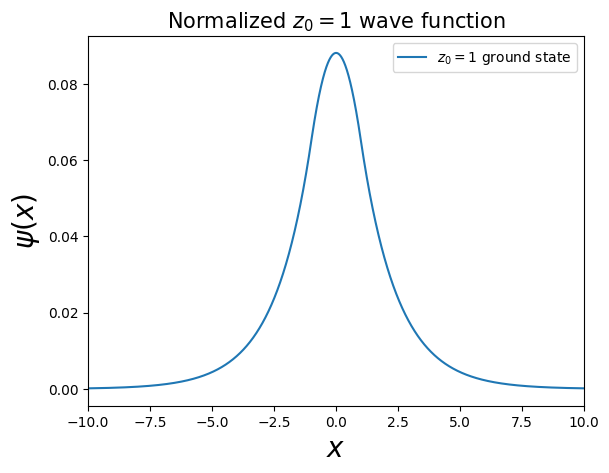

In [38]:
import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np

fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

# set the labels and titles:
ax.set_ylabel(r'$\psi(x)$', fontsize=20) # set the x label
ax.set_xlabel(r'$x$', fontsize=20) # set the y label. Note that the 'r' is necessary to remove the need for double slashes. You can use LaTeX! 
ax.set_title('Normalized $z_0=1$ wave function', fontsize=15) # set the title 

# make a one-dimensional plot using the above arrays, add a custom label
ax.plot(x, ynorm, label='$z_0=1$ ground state') 

# construct the legend:
ax.legend(loc='upper right')  # Add a legend

ax.set_xlim(-10,10)

plt.show() # show the plot here

(c) The $z_0=8$ wave functions are also easy to plot. For simplicity, let's create a function that calculates the wave functions given the eigenvalue. 

In [17]:
# this function *REQUIRES* the true eigenvalue as input
def EigenfunctionsSquareWell(z0, eps, k2func):
    """Returns the Eigenfunctions given the eigenvalue eps"""
    # Get the two Numerof pieces:
    xf,yf = NumerovForward(lambda x: k2func(x, z0, eps), lambda x: 0, 0, 1, stepsize, -20, -1)
    xb,yb = NumerovBackward(lambda x: k2func(x, z0, eps), lambda x: 0, 0, 1, stepsize, 20, -1)
    # enforce continuity at x = -1:
    norm = yf[-1]/yb[1]
    # renormalize yb to get continuity:
    yb = yb*norm

    # concatenate, taking care to remove the overlapping points:
    x = np.concatenate((xf,xb[2:]))
    y = np.concatenate((yf,yb[2:]))

    # normalize the wave function to unity:
    normfactor = np.linalg.norm(np.square(y))
    ynorm = y/np.sqrt(normfactor)
    # return:
    return x,ynorm

yz08 = []
for eigenv in Eigenvalues_z0_8:
    x, y = EigenfunctionsSquareWell(8, eigenv, k2)
    yz08.append(y)

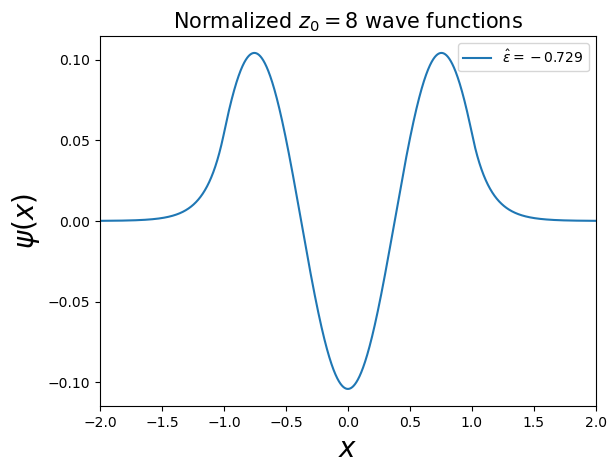

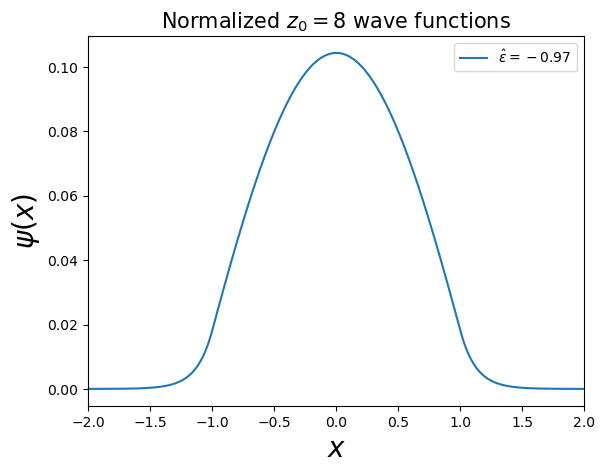

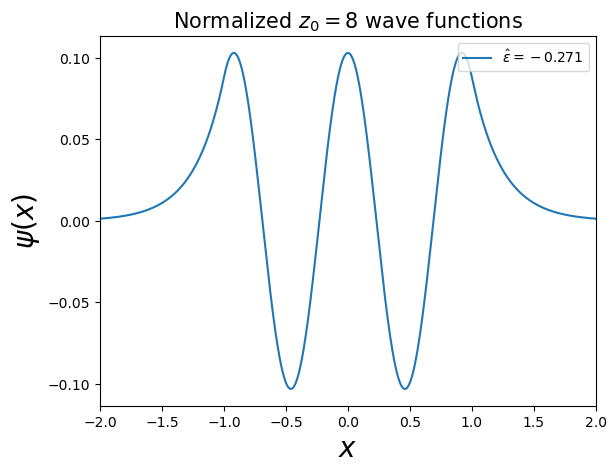

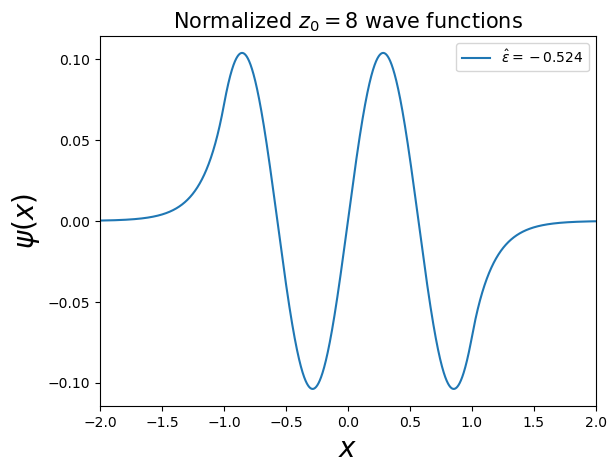

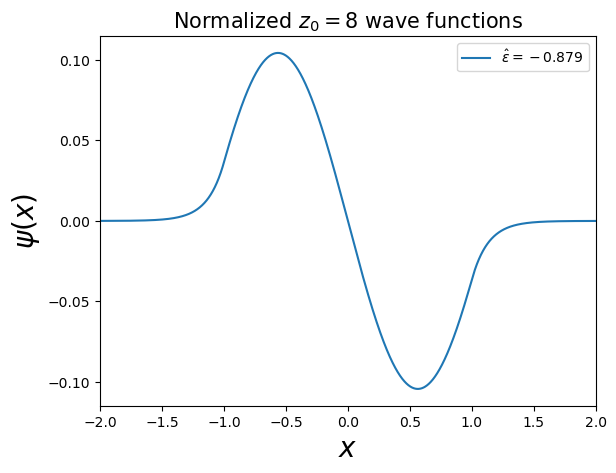

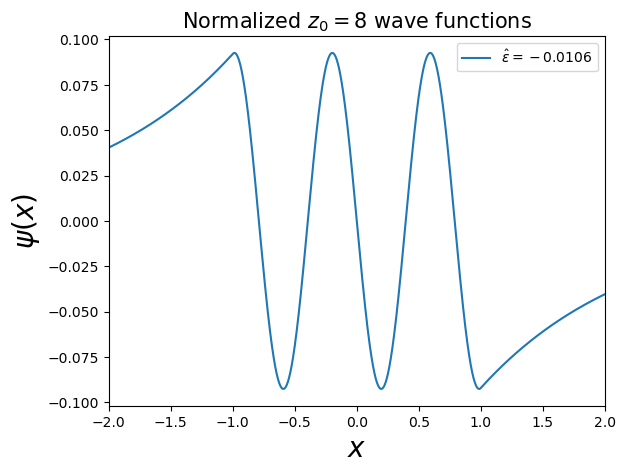

In [19]:
def round_sig(x, sig=3):
    """Rounds to sig significant figures"""
    if x == 0.:
        return 0.
    if math.isnan(x) is True:
        print('Warning, NaN!')
        return 0.
    return round(x, sig-int(np.floor(np.log10(abs(x))))-1)

import matplotlib.pyplot as plt # import matplotlib, a conventional module name is plt
import numpy as np

for i, y in enumerate(yz08):
    fig, ax = plt.subplots() # create the elements required for matplotlib. This creates a figure containing a single axes.

    # set the labels and titles:
    ax.set_ylabel(r'$\psi(x)$', fontsize=20) # set the x label
    ax.set_xlabel(r'$x$', fontsize=20) # set the y label. Note that the 'r' is necessary to remove the need for double slashes. You can use LaTeX! 
    ax.set_title('Normalized $z_0=8$ wave functions', fontsize=15) # set the title 

    ax.plot(x, y, label=r'$\hat{\epsilon}=' + str(round_sig(Eigenvalues_z0_8[i])) + '$') 

    # construct the legend:
    ax.legend(loc='upper right')  # Add a legend

    ax.set_xlim(-2,2)

    plt.show() # show the plot here